# Axially-sliced field plots

Another notebook in the series of analysis of Mark's trap array design. 

For an array of dark traps.

In [1]:
## general imports
import numpy as np
from numpy import *
from numpy.fft import fft,fft2,fftshift,ifftshift

from scipy.special import j0, j1
from matplotlib import colors
import matplotlib.pyplot as plt
from time import time
from random import random as rand

## local imports
import os,sys
sys.path.append(os.path.join("..","."))
from field_funcs import * # my helper functions
from physconsts import *

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

# image path 
imagedir = os.path.join('..','images')
print("images saved in", imagedir)

# for matplotlib labels
fontsize=14

def savefigure(fname):
    filepath = os.path.join(imagedir,fname)
    plt.savefig(filepath, bbox_inches='tight')
    print("saved file to",filepath)

images saved in ..\images


## Uniform spot phases

Give all the field going through all the spots the same relative phase difference wrt the field passing through the background.  

In [3]:
## physics and lens params
# lengths in m

lmbda = 8.05e-7
nu0 = c/lmbda
dnu = 1e6 # full-width half maximum of spectrum

# lorentzian scaled to have peak value = 1
L = lambda nu: lorentzian(nu, nu0, dnu)/lorentzian(nu0,nu0,dnu)
k = 2*pi/lmbda

f1 = 0.5 # lens focal length
f2 = 0.005
A0 = 1 # input field amplitude

# input mask params
a = 1e-4 # spot radius
dx = 4.3*a # grid periodicity
dy = dx
b = f1*3.8317/(a*k) # fourier plane filter radius
xnum1 = ynum1 = 10 # number of grid points in each dimension

## output field Talbot lengths
Lx2 = f2*dx/f1 # output array periodicity
Ly2 = f2*dy/f1
zTalbotx = 2*Lx2**2/lmbda 
zTalboty = 2*Ly2**2/lmbda 

## print out parameters
print("length units are m:")
print(f'b={b:0.6f}, a={a}, dx={dx}, dy={dy}, xnum={xnum1}, ynum={ynum1}')
print(f'zTalbotx={zTalbotx:0.6f}, zTalboty={zTalboty:0.6f}')

length units are m:
b=0.002455, a=0.0001, dx=0.00043, dy=0.00043, xnum=10, ynum=10
zTalbotx=0.000046, zTalboty=0.000046


(-3.141592653589793, 3.141592653589793)

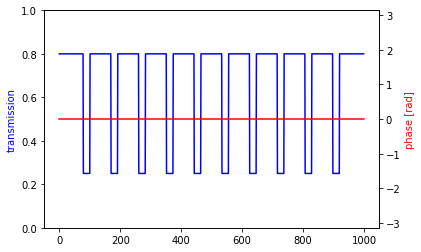

In [4]:
## create a mask that induces a phase difference between spots and background

pts = 1000
phi_std=None # [rad]
pos_std=None
r_aper = .75 # aperture reflectivity
t_plate = 0.8 # plate transmissivity

# the mask with desired transmission properties
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1-r_aper, plate=t_plate)

field0 = mask

fig,ax1 = plt.subplots()
ax1.plot(range(pts), abs(field0[800,:]),color='blue')
ax1.set_ylabel("transmission",color='blue')
ax1.set_ylim((0,1))

ax2 = ax1.twinx()
ax2.plot(range(pts), angle(field0[800,:]),color='red')
ax2.set_ylabel("phase [rad]",color='red')
ax2.set_ylim((-pi,pi))

# plt.imshow(real(conjugate(field0)*field0))

In [44]:
help(spot_mask)

Help on function spot_mask in module field_funcs:

spot_mask(xnum, ynum, a, dx, dy, pts, pos_std=None, phi_std=None, plate=0, aperture=1)
    Args:
        xnum: # of spots in x (columns)
        ynum " " " " y (rows)
        a: aperture spot radius
        dx: center-center distance in x
        dy: " " " " y
        pts: number of pts in one dimesnsion in the 2D array output. ie output
            mask is pts x pts
        pos_std: std for randomness added to spot centers. should be a decimal 
            representing percentage of 'a', e.g. 0.10 would give normally
            distributed noise with sigma = 0.10*a
        phi_std: std for random phase given to each aperture unit cell. units are in 2*pi and phase is sampled from
            from a normal dist. phi_std = 0.1 would correspond to sigma 0.1*2*pi radians, so there is a 
            +/- 10% spread of phase over the apertures compared to the plate. Note that to create mask where 
            this phase is only applied to th

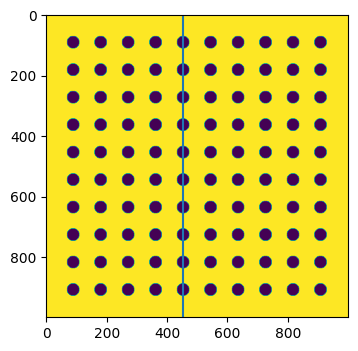

In [5]:
plt.close()
fig,ax = plt.subplots(dpi=100)
plt.imshow(abs(field0))
ax.axvline(453)

In [24]:
# input mask
pts = 1000
phi_std=None # [rad]
pos_std=None
r_aper = .75 # aperture reflectivity
t_plate = 0.8 # plate transmissivity
mask, x0pts, w = spot_mask(xnum1, ynum1, a, dx, dy, pts, phi_std=phi_std, pos_std=pos_std, aperture=1-r_aper, plate=t_plate)

# axial position steps after lens f2
numsteps = 201
dz2_steps = linspace(-zTalbotx,zTalbotx,numsteps) # ensure dz2=0 included for normalization purposes
I2max = 1

field0 = mask

z2 = f2 # output plane

# FOURIER PLANE FIELD -- propogate the field and apply a filter in the Fourier plane
padding= int(pts/2) 
rr0 = sqrt(x0pts**2 + x0pts.reshape(-1,1)**2)
field1,x1pts = lens_xform(f1,field0,b,f1,k,x0pts,rr0,padding,masked=False,padval=1,
                          logging=False)

xslice = 453 # x coordinate of the slice
slices_soln = empty((pts,numsteps),dtype=float) 
t0 = time()
for i,dz2 in enumerate(dz2_steps):

    # OUTPUT FIELD -- propagate field in Fourier plane to z2 behind lens f2 
    rr1 = sqrt(x1pts**2 + x1pts.reshape(-1,1)**2)
    field2,x2pts = lens_xform(z2+dz2,field1,b,f2,k,x1pts,rr1,padding,masked=True,
                              logging=False)
    
    if dz2 == 0:
        I2max = max(abs(field2[:,xslice])**2)
        print("obtained normalization factor")
    
    slices_soln[:,i] = abs(field2[:,xslice])**2
    print(f"step {i} completed")
    
for i in range(numsteps):
    slices_soln[:,i] /= I2max
    
print(f"simulation completed in {floor(100*(time()-t0)/60)/100} minutes")

step 0 completed
step 1 completed
step 2 completed
step 3 completed
step 4 completed
step 5 completed
step 6 completed
step 7 completed
step 8 completed
step 9 completed
step 10 completed
step 11 completed
step 12 completed
step 13 completed
step 14 completed
step 15 completed
step 16 completed
step 17 completed
step 18 completed
step 19 completed
step 20 completed
step 21 completed
step 22 completed
step 23 completed
step 24 completed
step 25 completed
step 26 completed
step 27 completed
step 28 completed
step 29 completed
step 30 completed
step 31 completed
step 32 completed
step 33 completed
step 34 completed
step 35 completed
step 36 completed
step 37 completed
step 38 completed
step 39 completed
step 40 completed
step 41 completed
step 42 completed
step 43 completed
step 44 completed
step 45 completed
step 46 completed
step 47 completed
step 48 completed
step 49 completed
step 50 completed
step 51 completed
step 52 completed
step 53 completed
step 54 completed
step 55 completed
st

In [ ]:
savefile = False

wrote file to plot_axial_field_slice_tplate80_rspot25_10x10.png


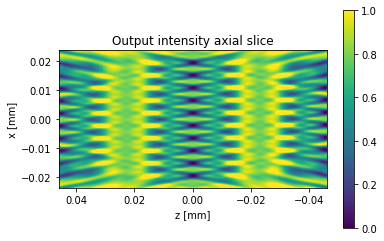

In [80]:
fig,ax = plt.subplots()#figsize=(6,8))
mmscl = 1e3
M = f2/f1
cax = ax.imshow(slices_soln, extent=[-dz2_steps[0]*mmscl,dz2_steps[0]*mmscl,-w*mmscl*M,w*mmscl*M])
ax.set_xlabel("z [mm]")
ax.set_ylabel("x [mm]")
ax.set_title("Output intensity axial slice")

cax.set_norm(colors.Normalize(vmin=0, vmax=1))
ax.set_aspect(1)
cbar = fig.colorbar(cax)
if savefile:
    fname = f"plot_axial_field_slice_tplate{int(100*t_plate)}_rspot{int(100*(1-r_aper))}_{xnum1}x{xnum1}.png"
    plt.savefig(fname, bbox_inches='tight')
    print('wrote file to',fname)
    savefile = False

In [49]:
2*w/100

4.73e-05

In [30]:
w

0.002365

In [78]:
savefig=True

saved file to ..\images\plot_axial_trap_slices_tplate80_rspot25_10x10_5slices.png


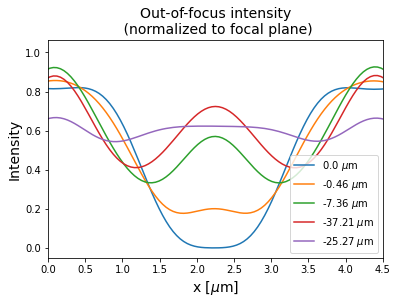

In [79]:
fig,ax = plt.subplots()
umscl = 1e6
xpts = linspace(-w*umscl*M,w*umscl*M,pts)
ipts = 5
for i in range(ipts):
    ax.plot(xpts,slices_soln[:,int((numsteps-1)/2)-i*(ipts-1)],label=f'{floor(100*dz2_steps[int((numsteps-1)/2)-i**(ipts-1)]*1e6)/100} $\mu$m')
ax.set_title("Out-of-focus intensity"+ "\n (normalized to focal plane)",fontsize=fontsize)
ax.set_xlabel("x [$\mu$m]",fontsize=fontsize)
ax.set_ylabel("Intensity",fontsize=fontsize)
# ax.set_ylim((0,0.2))
ax.set_xlim((0,4.5))
ax.legend()
if savefig:
    fname = f"plot_axial_trap_slices_tplate{int(100*t_plate)}_rspot{int(100*(1-r_aper))}_{xnum1}x{xnum1}_{ipts}slices.png"
    savefigure(fname)

In [101]:
f"plot_trap_min_vs_spot_phase_tplate{int(100*t_plate)}_rspot{int(100*(1-r_aper))}_{numsteps}pts.png"

'plot_trap_min_vs_spot_phase_tplate80_rspot25_101pts.png'

saved file to ..\images\plot_trap_min_vs_spot_phase_tplate80_rspot25_pi45_pf45_51pts.png


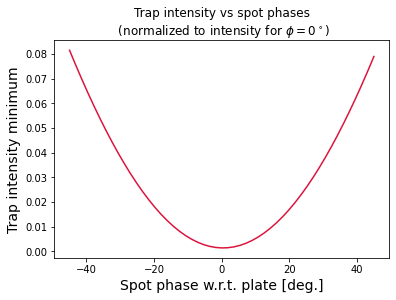

In [7]:
savefig=True
fig,ax = plt.subplots()
ax.set_title(r"Trap intensity vs spot phases" + "\n (normalized to intensity for $\phi=0^\circ$)" )
ax.set_xlabel("Spot phase w.r.t. plate [deg.]",fontsize=fontsize)
ax.set_ylabel(r"Trap intensity minimum",fontsize=fontsize)
ax.plot(phase_steps, [slices_soln[455,i] for i in range(numsteps)],color='crimson')
if savefig:
    fname = f"plot_trap_min_vs_spot_phase_tplate{int(100*t_plate)}_rspot{int(100*(1-r_aper))}_pi{abs(int(phase_steps[0]))}_pf{abs(int(phase_steps[-1]))}_{numsteps}pts.png"
    savefigure(fname)